In [1]:
# ========== 0. INSTALL DEPENDENCIES ==========
!pip install -q kagglehub opencv-python-headless decord flwr peft transformers 
!pip install -q torchvision datasets av sentencepiece accelerate bitsandbytes 
!pip install -q codecarbon scikit-learn seaborn tqdm
!pip install -q tensorboard

In [2]:
# ========== 1. IMPORTS ==========
import torch
import os
import json

from typing import Any

import kagglehub
from pathlib import Path
from random import sample
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, 
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support
)

from codecarbon import EmissionsTracker
from datasets import Dataset
from decord import VideoReader, cpu
from dataclasses import dataclass
from transformers import (
    AutoProcessor,
    LlavaNextVideoForConditionalGeneration,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ========== 2. CONFIGURATION ==========
class Config:
    path = kagglehub.dataset_download("yash07yadav/project-data")
    print(f"Dataset downloaded to: {path}")
    
    # Paths
    TRAIN_BASE_PATH = Path(path) / "Complete Dataset" / "train"
    EVAL_BASE_PATH = Path(path) / "Complete Dataset" / "val"
    
    # Model
    MODEL_ID = "llava-hf/LLaVa-NeXT-Video-7b-hf"
    LORA_RANK = 32
    OUTPUT_DIR = "./video-llava-finetuned"
    
    # Training
    BATCH_SIZE = 2
    GRAD_ACCUM_STEPS = 4
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    MAX_STEPS = 500
    LOGGING_STEPS = 50
    SAVE_STEPS = 200
    
    # Video Processing
    NUM_FRAMES = 24

config = Config()

Dataset downloaded to: /home/jovyan/.cache/kagglehub/datasets/yash07yadav/project-data/versions/1


In [4]:
# ========== 3. DATASET PREPARATION ==========
def load_video_paths(base_path, class_names=["NonFight", "Fight"]):
    """Load video paths with labels from structured directory"""
    dataset = {"videos": [], "labels": []}
    
    for label_idx, class_name in enumerate(class_names):
        # Verify download
        class_dir = base_path / class_name
        video_paths = list(class_dir.glob("*"))
        
        for path in video_paths:
            dataset["videos"].append(str(path))
            dataset["labels"].append(label_idx)
            
    return Dataset.from_dict(dataset)

# Initialize datasets
train_dataset = load_video_paths(config.TRAIN_BASE_PATH)
eval_dataset = load_video_paths(config.EVAL_BASE_PATH)

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

Training samples: 2000
Evaluation samples: 550


In [5]:
# ========== 4. MODEL INITIALIZATION ==========
def initialize_model():
    """Initialize model with 4-bit quantization and LoRA"""
    # Processor
    processor = AutoProcessor.from_pretrained(
        config.MODEL_ID,
        device_map="auto",
        use_fast=True,
        pad_token="<pad>"
    )
    
    # Quantization config
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )
    
    # Model
    model = LlavaNextVideoForConditionalGeneration.from_pretrained(
        config.MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.float16,
    )
    
    # LoRA config
    lora_config = LoraConfig(
        r=config.LORA_RANK,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
    
    # Prepare for training
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    model.gradient_checkpointing_enable()
    model.config.use_cache = False
    
    return model, processor

In [6]:
# ========== 5. DATA COLLATOR ==========
@dataclass
class VideoDataCollator:
    processor: Any
    
    def __call__(self, batch):
        """Handle list of individual examples"""
        conversations = []
        labels = []
        
        # Each example is a dict in the batch list
        for example in batch:
            video_path = example["videos"]
            label = example["labels"]
            
            # Create conversation template
            conv = [
                {
                    "role": "user",
                    "content": [
                        {"type": "video", "path": video_path},
                        {"type": "text", "text": "Analyze the video. Is this a fight scene? Answer with only yes or no"},
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": "yes" if label == 1 else "no"}]
                }
            ]
            conversations.append(conv)
        
        # Process all conversations
        inputs = self.processor.apply_chat_template(
            conversations,
            num_frames=config.NUM_FRAMES,
            tokenize=True,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=8192,
            return_dict=True
        )

        inputs["labels"] = inputs["input_ids"].clone()
        
        return inputs

In [7]:
# ========== 6. TRAINING SETUP ==========
def setup_training(model, processor):
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        per_device_train_batch_size=config.BATCH_SIZE,
        gradient_accumulation_steps=config.GRAD_ACCUM_STEPS,
        learning_rate=config.LEARNING_RATE,
        num_train_epochs=config.NUM_EPOCHS,
        max_steps=config.MAX_STEPS,
        logging_steps=config.LOGGING_STEPS,
        save_steps=config.SAVE_STEPS,
        fp16=True,
        remove_unused_columns=False,
        report_to="tensorboard",
        logging_dir="./logs",
        save_total_limit=2,
    )
    
    return SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=VideoDataCollator(processor),
    )

In [8]:
# ========== 7. TRAINING EXECUTION ==========
def train_model():
    # Initialize
    model, processor = initialize_model()
    trainer = setup_training(model, processor)
    
    # Track emissions
    # with EmissionsTracker(log_level="error") as tracker:
    print("Starting training...")
    trainer.train()
    # print(f"Training emissions: {tracker.final_emissions} kg CO2")
    
    # Save model
    trainer.save_model(config.OUTPUT_DIR)
    processor.save_pretrained(config.OUTPUT_DIR)
    print(f"Model saved to {config.OUTPUT_DIR}")
    
    return model, processor

In [9]:
# ========== 8. EVALUATION ==========
class VideoEvaluator:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = model.device
        
    def predict(self, video_path):
        """Make prediction for a single video"""
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "video", "path": video_path},
                    {"type": "text", "text": "Analyze the video. Is this a fight scene? Answer with only yes or no"},
                ],
            }
        ]
        
        inputs = self.processor.apply_chat_template(
            conversation,
            num_frames=config.NUM_FRAMES,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(self.device, torch.float16)
        
        outputs = self.model.generate(**inputs, max_new_tokens=10)
        prediction = self.processor.batch_decode(
            outputs, 
            skip_special_tokens=True
        )[0].strip().lower().split()[-1].replace(".", "")

        return 1 if "yes" in prediction else 0
    
    def evaluate(self, dataset):
        """Full evaluation on dataset"""
        results = []
        for video_path, true_label in tqdm(
            zip(dataset["videos"], dataset["labels"]),
            total=len(dataset),
            desc="Evaluating"
        ):
            try:
                pred_label = self.predict(video_path)
                results.append({
                    "video": video_path,
                    "true": true_label,
                    "pred": pred_label
                })
            except Exception as e:
                print(f"Error processing {video_path}: {str(e)}")
                
        return pd.DataFrame(results)

def analyze_results(results_df):
    """Comprehensive results analysis"""
    # Metrics
    accuracy = accuracy_score(results_df["true"], results_df["pred"])
    precision, recall, f1, _ = precision_recall_fscore_support(
        results_df["true"], results_df["pred"], average="binary"
    )
    roc_auc = roc_auc_score(results_df["true"], results_df["pred"])
    
    # Confusion Matrix
    cm = confusion_matrix(results_df["true"], results_df["pred"])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Fight", "Fight"],
                yticklabels=["Non-Fight", "Fight"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(results_df["true"], results_df["pred"])
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(results_df["true"], results_df["pred"]))

Loading checkpoint shards: 100%|██████████| 3/3 [00:17<00:00,  5.85s/it]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
50,51.660800
100,25.753900
150,17.768000
200,16.830100
250,16.449700
300,16.145600
350,15.928500
400,15.799300
450,15.733900
500,15.704100


/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Model saved to ./video-llava-finetuned


/opt/conda/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Evaluating: 100%|██████████| 550/550 [43:17<00:00,  4.72s/it]


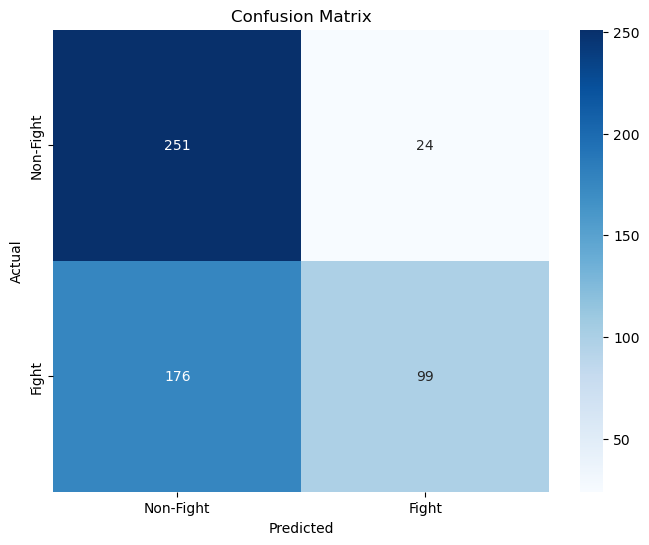

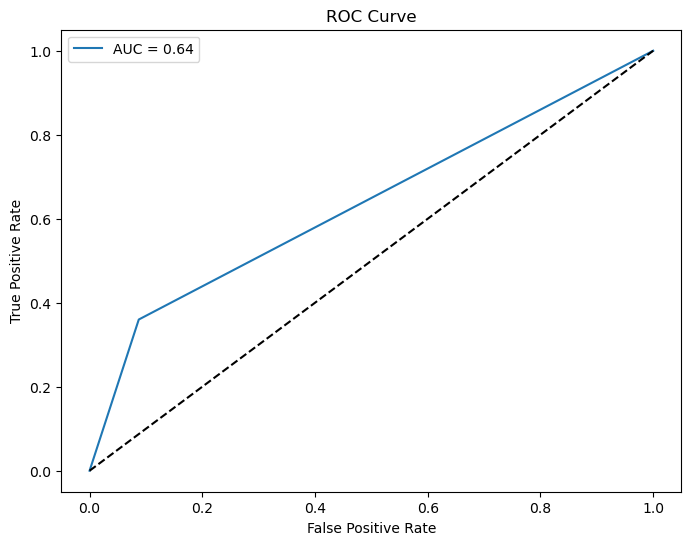

Accuracy: 0.6364
Precision: 0.8049
Recall: 0.3600
F1 Score: 0.4975
ROC-AUC: 0.6364

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.91      0.72       275
           1       0.80      0.36      0.50       275

    accuracy                           0.64       550
   macro avg       0.70      0.64      0.61       550
weighted avg       0.70      0.64      0.61       550

Evaluation results saved to fight_detection_results.csv


In [10]:
# ========== 9. MAIN EXECUTION ==========
if __name__ == "__main__":
    import gc

    gc.collect()
    
    torch.cuda.empty_cache()
    
    # Train
    model, processor = train_model()
    
    # Evaluate
    evaluator = VideoEvaluator(model, processor)
    eval_results = evaluator.evaluate(eval_dataset)
    
    # Analyze
    analyze_results(eval_results)
    
    # Save results
    eval_results.to_csv("fight_detection_results.csv", index=False)
    print("Evaluation results saved to fight_detection_results.csv")